Calculation of the total energy of the $\text{H}_2$ ground state using the Hartree-Fock method by https://github.com/nickelandcopper/HartreeFockPythonProgram. Developed to calculate the coefficients of the Second Quantization Hamiltonian minimum basis set.

### Second quantization Hamiltonian:

$$ \hat{H_e} = \sum_{pq=0}^{n} h_{pq}a^{\dagger}_{p}a_{q} + \frac{1}{2} \sum_{pqrs=0}^{n} h_{pqrs} a^{\dagger}_{p}a^{\dagger}_{q}a_{r}a_{s}  $$

### 1-body integral:

$$ h_{pq} = \int d\mathbf{r} \, \Phi_p^*(\mathbf{r}) \left( -\frac{1}{2} \nabla^2 - \sum_{a=1}^{M} \frac{Z_a}{\lVert \mathbf{r} - \mathbf{R}_a \rVert} \right) \Phi_q(\mathbf{r}) $$

### 2-body integral:
$$ h_{pqrs} = \iint d\mathbf{r}_1 \, d\mathbf{r}_2 \;\Phi_p^*(\mathbf{r}_1) \, \Phi_q^*(\mathbf{r}_2) \,\frac{1}{\lVert \mathbf{r}_1 - \mathbf{r}_2 \rVert} \, \Phi_r(\mathbf{r}_1) \, \Phi_s(\mathbf{r}_2) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import linalg

In [2]:
# Build primitive Gaussian minimum basis set
class primitive_gaussian():
    def __init__(self, alpha, coeff, coordinates, l1, l2, l3):
        self.alpha = alpha
        self.coeff = coeff
        self.coordinates = np.array(coordinates)
        self.A = (2.0 * alpha / np.pi) ** (3/4) # Wavefunction

# Calculate overlap wavefunction
def overlap(molecule):
    n_basis = len(molecule)
    S = np.zeros([n_basis, n_basis])
    
    for i in range(n_basis):
        for j in range(n_basis):
            nprimitives_i = len(molecule[i])
            nprimitives_j = len(molecule[j])
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):  
                    N = molecule[i][k].A * molecule[j][l].A
                    p = molecule[i][k].alpha + molecule[j][l].alpha
                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q, Q)
                    
                    S[i,j] += N * molecule[i][k].coeff * molecule[j][l].coeff * np.exp(-q * Q2) * (np.pi / p) ** (3 / 2) 
    
    return S

# Calculate kinetic energy
def kinetic(molecule):
    n_basis = len(molecule)
    T = np.zeros([n_basis, n_basis])
    
    for i in range(n_basis):
        for j in range(n_basis):
            nprimitives_i = len(molecule[i])
            nprimitives_j = len(molecule[j])
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):
                    N = molecule[i][k].A * molecule[j][l].A
                    cacb = molecule[i][k].coeff * molecule[j][l].coeff
                    
                    p   = molecule[i][k].alpha + molecule[j][l].alpha
                    P   = molecule[i][k].alpha * molecule[i][k].coordinates +  molecule[j][l].alpha * molecule[j][l].coordinates
                    Pp  = P / p
                    PG  = Pp - molecule[j][l].coordinates
                    PGx2 = PG[0] ** 2
                    PGy2 = PG[1] ** 2
                    PGz2 = PG[2] ** 2

                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q, Q)
                
                    s = np.exp(-q * Q2) * (np.pi / p) ** (3 / 2) * N * cacb
                    
                    T[i, j] += 3.0 * molecule[j][l].alpha * s
                    T[i, j] -= 2.0 * molecule[j][l].alpha ** 2 * s * (PGx2 + 0.5 / p)
                    T[i, j] -= 2.0 * molecule[j][l].alpha ** 2 * s * (PGy2 + 0.5 / p)
                    T[i, j] -= 2.0 * molecule[j][l].alpha ** 2 * s * (PGz2 + 0.5 / p)

    return T

# Boys function
def boys(x, n):
    if x == 0:
        return 1.0 / (2 * n + 1)
    else:
        return special.gammainc(n + 0.5, x) * special.gamma(n + 0.5) * (1.0 / (2 * x**(n + 0.5)))

# Calculate electron-nuclear attraction interaction 
def electron_nuclear_attraction(molecule, Z):
    natoms = len(Z)
    n_basis = len(molecule)   
    coordinates = []

    for i in range(n_basis):
        nprimitives_i = len(molecule[i])
        for j in range(nprimitives_i):
            coordinates.append(molecule[i][j].coordinates)

    coordinates = np.array(coordinates)
    coordinates = np.unique(coordinates, axis=0)
    
    V_ne = np.zeros([n_basis, n_basis])
 
    for atom in range(natoms):
        for i in range(n_basis):
            for j in range(n_basis):
                nprimitives_i = len(molecule[i])
                nprimitives_j = len(molecule[j])
            
                for k in range(nprimitives_i):
                    for l in range(nprimitives_j):
                        N = molecule[i][k].A * molecule[j][l].A
                        cacb = molecule[i][k].coeff * molecule[j][l].coeff
                    
                        p = molecule[i][k].alpha + molecule[j][l].alpha
                        P = molecule[i][k].alpha * molecule[i][k].coordinates + molecule[j][l].alpha * molecule[j][l].coordinates
                        Pp = P / p
                        PG = Pp - coordinates[atom]
                        
                        PG2 = np.dot(PG, PG)

                        q = molecule[i][k].alpha * molecule[j][l].alpha / p
                        Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                        Q2 = np.dot(Q, Q)
                    
                        V_ne[i, j] += N * cacb * -Z[atom] * (2.0 * np.pi / p) * np.exp(-q * Q2) * boys(p * PG2, 0)
    return V_ne

# Calculate electron-electron repulsion interaction
def electron_electron_repulsion(molecule):
    n_basis = len(molecule)
    V_ee = np.zeros([n_basis, n_basis, n_basis, n_basis])
    
    for i in range(n_basis):
        for j in range(n_basis):
            for k in range(n_basis):
                for l in range(n_basis):
                    nprimitives_i = len(molecule[i])
                    nprimitives_j = len(molecule[j])
                    nprimitives_k = len(molecule[k])
                    nprimitives_l = len(molecule[l])
            
                    for p in range(nprimitives_i):
                        for q in range(nprimitives_j):
                            for r in range(nprimitives_k):
                                for s in range(nprimitives_l):

                                    N = molecule[i][p].A * molecule[j][q].A * molecule[k][r].A * molecule[l][s].A
                                    cicjckcl = molecule[i][p].coeff * molecule[j][q].coeff * molecule[k][r].coeff * molecule[l][s].coeff
                                    
                                    pij = molecule[i][p].alpha + molecule[j][q].alpha
                                    pkl = molecule[k][r].alpha + molecule[l][s].alpha
                                    
                                    Pij = molecule[i][p].alpha * molecule[i][p].coordinates + molecule[j][q].alpha * molecule[j][q].coordinates
                                    Pkl = molecule[k][r].alpha * molecule[k][r].coordinates + molecule[l][s].alpha * molecule[l][s].coordinates
                                    
                                    Ppij = Pij / pij
                                    Ppkl = Pkl / pkl
                                    
                                    PpijPpkl = Ppij - Ppkl
                                    PpijPpkl2 = np.dot(PpijPpkl, PpijPpkl)
                                    denom = 1.0 / pij + 1.0 / pkl
                                    
                                    qij = molecule[i][p].alpha * molecule[j][q].alpha / pij
                                    qkl = molecule[k][r].alpha * molecule[l][s].alpha / pkl

                                    Qij = molecule[i][p].coordinates - molecule[j][q].coordinates
                                    Qkl = molecule[k][r].coordinates - molecule[l][s].coordinates
                                    
                                    Q2ij = np.dot(Qij, Qij)
                                    Q2kl = np.dot(Qkl, Qkl)
                                    
                                    term1 = 2.0 * np.pi * np.pi / (pij * pkl)
                                    term2 = np.sqrt(np.pi / (pij + pkl))
                                    term3 = np.exp(-qij * Q2ij) 
                                    term4 = np.exp(-qkl * Q2kl)
                                    
                                    value = N * cicjckcl * term1 * term2 * term3 * term4 * boys(PpijPpkl2 / denom, 0)
                                    V_ee[i, j, k, l] += value
    return V_ee

# Calculate nuclear-nuclear repulsion energy
def nuclear_nuclear_repulsion_energy(atom_coords, zlist):
    assert (len(atom_coords) == len(zlist))
    natoms = len(zlist)
    E_NN = 0
    for i in range(natoms):
        Zi = zlist[i]
        for j in range(natoms):
            if j > i:
                Zj = zlist[j]
                Rijx = atom_coords[i][0] - atom_coords[j][0]
                Rijy = atom_coords[i][1] - atom_coords[j][1]
                Rijz = atom_coords[i][2] - atom_coords[j][2]
                Rijx_squared = Rijx*Rijx
                Rijy_squared = Rijy*Rijy
                Rijz_squared = Rijz*Rijz             
                Rij = np.sqrt(Rijx_squared + Rijy_squared + Rijz_squared)      
                E_NN += (Zi*Zj)/Rij           
    return E_NN

# Calculate Hamiltonian
def compute_hamiltonian(molecule, Z):
    S = overlap(molecule)
    T = kinetic(molecule)
    V_ne = electron_nuclear_attraction(molecule, Z)
    V_ee = electron_electron_repulsion(molecule)
    H = T + V_ne

    return H, S, V_ee

# Calculate diagonalization and coefficient
def diagonalization_hamiltonian(H, S, molecule):
    S_chol = np.linalg.cholesky(S)
    H_prime = np.linalg.solve(S_chol.T, np.linalg.solve(S_chol, H))
    eigenvalues, _ = np.linalg.eigh(H_prime)
    overlap_v = overlap(molecule)[0][1]

    a = 1/np.sqrt(2*(1-overlap_v))
    b = 1/np.sqrt(2*(1+overlap_v))
    C = np.array([[b, -a], [b, a]], dtype=np.float64)
    C_prime = C.T
    return np.diag(eigenvalues), C_prime

# Calculate h_pqrs coefficient
def transform_integrals(V_ee, C):
    nbasis = C.shape[0]
    V_mo = np.zeros([nbasis, nbasis, nbasis, nbasis], dtype=np.float64)
    for i in range(nbasis):
        for j in range(nbasis):
            for k in range(nbasis):
                for l in range(nbasis):
                    term = 0
                    for p in range(nbasis):
                        for q in range(nbasis):
                            for r in range(nbasis):
                                for s in range(nbasis):
                                    term += C[i, p] * C[j, q] * C[k, r] * C[l, s] * V_ee[p, q, r, s]      
                    V_mo[i, j, k, l] = term
    return V_mo

In [6]:
# Initialization of Gaussian primitive basis set coefficients at https://www.basissetexchange.org/

H1_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, [0,0,0], 0, 0, 0)
H1_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, [0,0,0], 0, 0, 0)
H1_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, [0,0,0], 0, 0, 0)

H1_pg2a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, [0,0,1.4], 0, 0, 0)
H1_pg2b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, [0,0,1.4], 0, 0, 0)
H1_pg2c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, [0,0,1.4], 0, 0, 0)

zlist = [1.0, 1.0]
atom_coords = [np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 1.4])]

H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]
H2_1s = [H1_pg2a, H1_pg2b, H1_pg2c]

molecule = [H1_1s, H2_1s]
H, S, V_ee = compute_hamiltonian(molecule, zlist)
eigenvalues, C = diagonalization_hamiltonian(H, S, molecule)
V_mo = transform_integrals(V_ee, C)

print("\n")
print("\nOverlap matrix of H2 molecule in STO-3G basis:\n", overlap(molecule))
print("\nKinetic energy matrix of H2 molecule in STO-3G basis:\n", kinetic(molecule))
print("\nElectron nuclear attraction matrix of H2 molecule in STO-3G basis:\n", electron_nuclear_attraction(molecule,[1.0,1.0]))
print("\nOne Atomic Orbital:\n", H)
print("\nElectron electron repulsion matrix of H2 molecule in STO-3G basis:\n", electron_electron_repulsion(molecule))
print("\nNuclears Repulsion Energy:\n", nuclear_nuclear_repulsion_energy(atom_coords, zlist))
print("\nMolecular Orbital Coefficients:\n", C.T)
print("\nElectron one molecule orbital:\n", eigenvalues)
print("\nElectron-electron Repulsion Integral (MO Basis):\n", V_mo)




Overlap matrix of H2 molecule in STO-3G basis:
 [[1.         0.65931821]
 [0.65931821 1.        ]]

Kinetic energy matrix of H2 molecule in STO-3G basis:
 [[0.76003188 0.23645466]
 [0.23645466 0.76003188]]

Electron nuclear attraction matrix of H2 molecule in STO-3G basis:
 [[-1.88044089 -1.19483462]
 [-1.19483462 -1.88044089]]

One Atomic Orbital:
 [[-1.12040901 -0.95837996]
 [-0.95837996 -1.12040901]]

Electron electron repulsion matrix of H2 molecule in STO-3G basis:
 [[[[0.77460594 0.44410766]
   [0.44410766 0.56967593]]

  [[0.44410766 0.29702854]
   [0.29702854 0.44410766]]]


 [[[0.44410766 0.29702854]
   [0.29702854 0.44410766]]

  [[0.56967593 0.44410766]
   [0.44410766 0.77460594]]]]

Nuclears Repulsion Energy:
 0.7142857142857143

Molecular Orbital Coefficients:
 [[ 0.54893404 -1.21146407]
 [ 0.54893404  1.21146407]]

Electron one molecule orbital:
 [[-1.25279706  0.        ]
 [ 0.         -0.47560231]]

Electron-electron Repulsion Integral (MO Basis):
 [[[[ 6.74594086e-0

In [4]:
def compute_G(density_matrix, Vee):
    nbasis_functions = density_matrix.shape[0]
    G = np.zeros((nbasis_functions, nbasis_functions))
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            for k in range(nbasis_functions):
                for l in range(nbasis_functions):
                    density = density_matrix[k,l]
                    J = Vee[i,j,k,l]
                    K = Vee[i,l,k,j]
                    G[i,j] += density*(J-0.5*K)
    return G


def compute_density_matrix(mos):
    nbasis_functions = mos.shape[0]
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    # P = occ*CC_dagger
    occupation = 2.0
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            # mo is (natomic_orbtials x nMOs)
            for oo in range(number_occupied_orbitals):
                C = mos[i, oo]
                C_dagger = mos[j, oo]
                density_matrix[i,j] += occupation * C * C_dagger 
    return density_matrix


def compute_electronic_energy_expectation_value(density_matrix, T, Vne, G):
    Hcore = T + Vne
    electronic_energy = 0.0
    nbasis_functions = density_matrix.shape[0]
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            electronic_energy += density_matrix[i,j] * (Hcore[i,j] + 0.5*G[i,j])
    return electronic_energy


def scf_cycle(molecular_terms, scf_parameters, molecule):
    S, T, Vne, G = molecular_terms
    tolerance, max_scf_steps = scf_parameters
    electronic_energy = 0.0
    nbasis_functions = len(molecule)
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    
    # 1. Enter into the SCF cycles
    for scf_step in range(max_scf_steps):
        
        electronic_energy_old = electronic_energy
        
        # 2. Compute the 2 electron term, and add it to the 1 electron term
        G = compute_G(density_matrix, Vee)
        
        # 3. Form F, make S unit, then get eigenvalues and eigenvectors - transform eigenvectors back (w.o unitS)
        F = T + Vne + G
        # S^{-1/2} S S^{-1/2}
        S_inverse = linalg.inv(S)
        S_inverse_sqrt = linalg.sqrtm(S_inverse)
        # S^{-1/2} F S^{-1/2}
        F_unitS = np.dot(S_inverse_sqrt, np.dot(F, S_inverse_sqrt))
        eigenvalues, eigenvectors = linalg.eigh(F_unitS)
        mos = np.dot(S_inverse_sqrt, eigenvectors)

        # 4. Form new density matrix using MOs
        density_matrix = compute_density_matrix(mos)
        
        # 5. Compute electronic_energy expectation value
        electronic_energy = compute_electronic_energy_expectation_value(density_matrix, T, Vne, G)
        
        # 6. Check convergence
        if abs(electronic_energy-electronic_energy_old) < tolerance:
            return electronic_energy
    
    print("Warning: Convergence not met")
    return electronic_energy

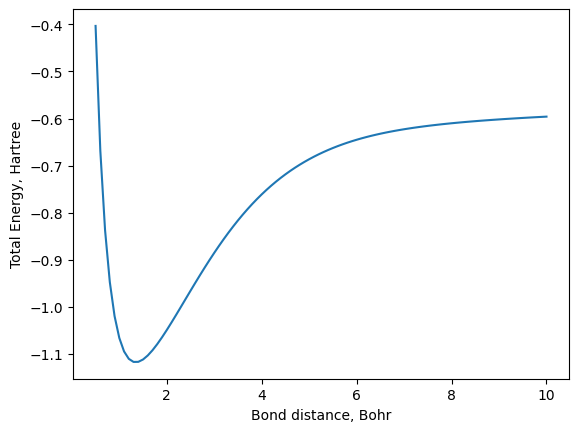

In [5]:
# create many H2 molecules
distances = np.arange(0.5, 10.1, 0.1) # in unit = bohr (a.u of position)
molecule_coordinates = [ [[0.0, 0.0, 0.0], [0.0, 0.0, distance]] for distance in distances]
total_energies = []
for molecule_coordinate in molecule_coordinates:

    # create H2 molecule - sto-3g basis
    H1_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[0], 0, 0, 0)
    H1_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, molecule_coordinate[0], 0, 0, 0)
    H1_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[0], 0, 0, 0)
    H2_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[1], 0, 0, 0)
    H2_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, molecule_coordinate[1], 0, 0, 0)
    H2_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[1], 0, 0, 0)
    number_occupied_orbitals = 1
    zlist = [1.0, 1.0]
    atom_coords = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]
    H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c]
    molecule = [H1_1s, H2_1s]
    
    # compute scf energy (electronic energy)
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, [1.0, 1.0])
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coords, zlist)
    molecular_terms = [S, T, Vne, Vee]
    scf_parameters = [1e-8, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    # compute total energy - electronic_energy + Enn
    total_energy = electronic_energy + Enn
    total_energies.append(total_energy)
    
# plot bond dissociation curve
plt.xlabel("Bond distance, Bohr")
plt.ylabel("Total Energy, Hartree")
plt.plot(np.array(distances), total_energies)